In [1]:
import h5py, os, pystan
import numpy as np
from os.path import dirname
import pandas as pd
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
df = pd.read_csv('two_step_data.txt')

In [3]:
print(df)

                               subject  trial  drift_1  drift_2  drift_3  \
0       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      1    0.743    0.273    0.717   
1       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      2    0.714    0.290    0.712   
2       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      3    0.709    0.346    0.714   
3       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      4    0.732    0.339    0.704   
4       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      5    0.717    0.408    0.722   
...                                ...    ...      ...      ...      ...   
341994  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    196    0.384    0.712    0.479   
341995  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    197    0.373    0.734    0.460   
341996  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    198    0.440    0.748    0.461   
341997  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    199    0.471    0.737    0.468   
341998  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    200    0.487    0.736    0.447   

        drift_4  stage_1_choice  stage_1_rt  transition  stage_2_choice  \
0         0.

In [4]:
from tqdm import tqdm
import seaborn as sns
sns.set('notebook', style='white', font='sans-serif', font_scale=1.33)

In [5]:
df = df.dropna()

In [6]:
df.reset_index(inplace=True)

In [7]:
subjects = df['subject']

In [8]:
subdata = df.loc[df['subject'] == subjects[1]]

In [9]:
subdata['subject']

0      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
1      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
2      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
3      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
4      3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
                    ...              
164    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
165    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
166    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
167    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
168    3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO
Name: subject, Length: 169, dtype: object

In [10]:
subs = np.unique(df['subject'])

In [11]:
len(subs)

1709

In [12]:
data = []
for s in subs[1550:1570]:
    subdata = df.loc[df['subject'] == s]
    
    r = subdata['outcome']
    Y1 = subdata['stage_1_choice'] - 1
    transition = subdata['transition']
    
    t = np.where(Y1 == transition, 1, 0)
    y1F = np.array(Y1[1:])
    y1B = np.array(Y1[:-1])
    
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = np.where(y1B == y1F, 1, 0)
    
    g = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(g)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


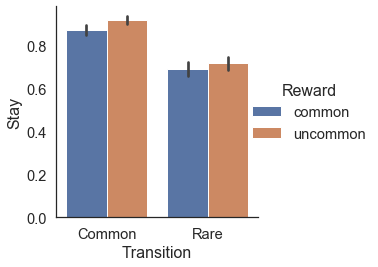

In [13]:
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

# Stan Testing

In [15]:
import os, pystan
import _pickle as pickle

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

In [16]:
PATH_NAME = '/Users/kierstenmarr/Desktop/EA'

In [17]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'EA.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [24]:
subdata = df.loc[df['subject'] == subs[1]]

In [25]:
subdata

,index,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
169,200,304SM51WA34XCM4E67SL28LY2UCBS4,1,0.743,0.273,0.717,0.479,1.0,2.196,1.0,1.0,2.0,1.179,1.0
170,201,304SM51WA34XCM4E67SL28LY2UCBS4,2,0.714,0.290,0.712,0.456,2.0,1.241,1.0,1.0,3.0,1.164,1.0
171,202,304SM51WA34XCM4E67SL28LY2UCBS4,3,0.709,0.346,0.714,0.466,2.0,0.994,1.0,1.0,3.0,0.493,1.0
172,203,304SM51WA34XCM4E67SL28LY2UCBS4,4,0.732,0.339,0.704,0.386,2.0,0.553,1.0,1.0,3.0,0.436,1.0
173,204,304SM51WA34XCM4E67SL28LY2UCBS4,5,0.717,0.408,0.722,0.422,1.0,0.530,0.0,1.0,3.0,0.772,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,395,304SM51WA34XCM4E67SL28LY2UCBS4,196,0.384,0.712,0.479,0.387,2.0,0.520,0.0,2.0,2.0,0.324,0.0
364,396,304SM51WA34XCM4E67SL28LY2UCBS4,197,0.373,0.734,0.460,0.375,2.0,1.593,1.0,2.0,3.0,1.828,1.0
365,397,304SM51WA34XCM4E67SL28LY2UCBS4,198,0.440,0.748,0.461,0.410,2.0,0.538,1.0,2.0,3.0,0.860,1.0
366,398,304SM51WA34XCM4E67SL28LY2UCBS4,199,0.471,0.737,0.468,0.375,2.0,1.138,1.0,2.0,3.0,0.845,0.0


In [41]:
r = subdata['outcome'].astype(int)
Y1 = (subdata['stage_1_choice'] - 1).astype(int)
Y2 = (subdata['stage_2_choice'] - 1).astype(int)
S2 = (subdata["stage_2_state"] - 2).astype(int)
transition = subdata['transition'].astype(int)
t = (np.where(Y1 == transition, 1, 0)).astype(int)
T = len(subdata)

In [42]:
# NOTE: haven't run whole block yet!
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [43]:
StanModel.optimizing(data=dd)

OrderedDict([('eta1_pr', array(-0.33598916)),
             ('eta2_pr', array(-0.36216315)),
             ('beta1_pr', array(-2.11954778)),
             ('beta2_pr', array(-2.78483893)),
             ('w_pr', array(0.5270087)),
             ('p_pr', array(0.00012109)),
             ('eta1', array(0.36831494)),
             ('eta2', array(0.3584855)),
             ('beta1', array(0.33977671)),
             ('beta2', array(0.05080411)),
             ('w', array(0.70104458)),
             ('p', array(0.50004836)),
             ('Y1_pd', array(0.4983963)),
             ('Y2_pd', array(0.49788694))])

In [44]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [45]:
print(StanFit)

Inference for Stan model: anon_model_bffbd421009e6eded8ba0311899b7864.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta1_pr   -1.17    0.03   1.38  -3.17  -2.35  -1.39  -0.12    1.6   2091    1.0
eta2_pr   -0.97    0.03   1.44   -3.7  -1.97  -0.82   0.09   1.53   2466    1.0
beta1_pr  -1.51    0.03   1.13  -3.15  -2.31  -1.82   -0.8   1.13   1768    1.0
beta2_pr  -2.51    0.02    0.9  -3.73  -3.03   -2.7  -2.29    0.1   1669    1.0
w_pr       0.44    0.02   1.02  -1.69  -0.21    0.5   1.12   2.34   4575    1.0
p_pr     2.7e-4    0.01    1.0  -1.96  -0.68 9.9e-3   0.68   1.98   5007    1.0
eta1       0.25  6.1e-3   0.31 6.6e-4 9.4e-3   0.08   0.45   0.95   2500    1.0
eta2        0.3  4.7e-3    0.3 7.6e-5   0.02   0.21   0.54   0.94   4049    1.0
beta1      3.22    0.11   4.88   0.01   0.21   0.69   4.21  17.41   1815    1.0
beta2      